In [1]:
#general tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3

#data processing tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from scipy import stats
import shap
from sklearn.neighbors import KNeighborsRegressor

#model building tools
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import Pool
import statsmodels.api as sm

#model productionalization tools
import pickle


In [2]:
#Establish connection with the local trulia housing .db SQLite file
conn = sqlite3.connect('C:/Users/dakot/Desktop/DataScience/projects/dakota_data_science_projects/santa_barbara_realestate_analysis/trulia_sb_house_data.db')

#read the "cleaned data" table from the trulia housing database and store in a pandas dataframe
df = pd.read_sql_query("SELECT * FROM trulia_house_SB_data_cleaned", conn)

In [3]:
#general summary information for the dataframe:
df.head()
df.columns

Index(['level_0', 'index', 'price', 'address', 'zip', 'num_bedrooms',
       'num_baths', 'building_sqft', 'year_built', 'lot_area',
       'home_description', 'feature_list', 'house_age', 'has_garage',
       'has_fireplace', 'has_ocean_views', 'has_mountain_views',
       'has_hope_ranch', 'has_montecito', 'has_pool', 'has_upstairs', 'has_IV',
       'building_sqft_was_missing'],
      dtype='object')

In [4]:
df.describe()

,level_0,index,price,num_bedrooms,num_baths,building_sqft,year_built,lot_area,house_age,has_garage,has_fireplace,has_ocean_views,has_mountain_views,has_hope_ranch,has_montecito,has_pool,has_upstairs,has_IV,building_sqft_was_missing
count,906.000000,906.000000,906.000000,906.000000,906.000000,750.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,633.844371,633.844371,2.697768,3.615894,3.197351,2.563863,1966.833333,0.837355,55.166667,0.390728,0.417219,0.112583,0.185430,0.045254,0.160044,0.239514,0.120309,0.003311,0.172185
std,374.363060,374.363060,1.902631,0.977273,1.391273,1.409905,24.700680,1.570894,24.700680,0.488183,0.493372,0.316257,0.388861,0.207975,0.366850,0.427023,0.325502,0.057480,0.377750
min,0.000000,0.000000,0.009500,2.000000,1.500000,0.668000,1900.000000,0.000002,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,307.250000,307.250000,1.360318,3.000000,2.000000,1.564000,1956.000000,0.170000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,623.000000,623.000000,1.980500,4.000000,3.000000,2.189500,1963.000000,0.260000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,957.750000,957.750000,3.490750,4.000000,4.000000,3.043750,1985.000000,1.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1296.000000,1296.000000,9.910000,9.000000,11.000000,10.823000,2021.000000,15.000000,122.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#drop features that are not useful for the model
df_model=df.drop(['level_0','index', 'address', 'year_built', 'home_description', 'feature_list'],axis=1)

In [6]:
#The only cataorical feature is the zipcode. Use one hot encoding to create dummy variables for zip code categories
enc=OneHotEncoder(handle_unknown='ignore')

enc_df=pd.DataFrame(enc.fit_transform(df[['zip']]).toarray())
enc_df.columns=enc.get_feature_names(['zip'])

df_model=df_model.join(enc_df)
df_model.head()

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,price,zip,num_bedrooms,num_baths,building_sqft,lot_area,house_age,has_garage,has_fireplace,has_ocean_views,...,building_sqft_was_missing,zip_93067,zip_93101,zip_93103,zip_93105,zip_93108,zip_93109,zip_93110,zip_93111,zip_93117
0,3.900000,93108,3.0,3.0,2.354,1.00,62.0,0,0,0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.780000,93105,3.0,2.0,1.395,0.14,73.0,1,1,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.350000,93105,3.0,2.0,1.344,0.50,50.0,0,1,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.899000,93109,3.0,3.0,2.558,0.50,42.0,0,1,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.824215,93109,4.0,2.0,1.407,0.14,63.0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
#Print the number of null values in each column 
print(df_model.isnull().sum())

price                          0
zip                            0
num_bedrooms                   0
num_baths                      0
building_sqft                156
lot_area                       0
house_age                      0
has_garage                     0
has_fireplace                  0
has_ocean_views                0
has_mountain_views             0
has_hope_ranch                 0
has_montecito                  0
has_pool                       0
has_upstairs                   0
has_IV                         0
building_sqft_was_missing      0
zip_93067                      0
zip_93101                      0
zip_93103                      0
zip_93105                      0
zip_93108                      0
zip_93109                      0
zip_93110                      0
zip_93111                      0
zip_93117                      0
dtype: int64


In [8]:
#Here we perform some imputation to approximate and fill in any nan values

def knn_imputer(df):
    #This function takes in a dataframe and imputes missing numeric values with a knn regressor

    #isolate the columns with categorical data
    cat_data=df.select_dtypes(exclude=[np.number])
    
    #isolate the columns with numeric data
    numeric_data=df.select_dtypes(include=[np.number])

    nan_columns=numeric_data.columns[numeric_data.isna().any()].tolist()

    no_nan_columns=numeric_data.drop(columns=nan_columns).columns

    for col in nan_columns:

        KNN_test_data=numeric_data[numeric_data[col].isna()]

        KNN_train_data=numeric_data.dropna()

        KNN_model=KNeighborsRegressor(n_neighbors=3)

        KNN_model.fit(KNN_train_data[no_nan_columns], KNN_train_data[col])

        numeric_data.loc[numeric_data[col].isna(),col]=KNN_model.predict(KNN_test_data[no_nan_columns])

    return pd.concat([numeric_data, cat_data], axis=1)

#df_model=knn_imputer(df_model)
df_model.dropna(subset=['building_sqft'], inplace=True)

In [9]:
#Print the number of null values in each column to ensure that no columns have null values
print(df_model.isnull().sum())

price                        0
zip                          0
num_bedrooms                 0
num_baths                    0
building_sqft                0
lot_area                     0
house_age                    0
has_garage                   0
has_fireplace                0
has_ocean_views              0
has_mountain_views           0
has_hope_ranch               0
has_montecito                0
has_pool                     0
has_upstairs                 0
has_IV                       0
building_sqft_was_missing    0
zip_93067                    0
zip_93101                    0
zip_93103                    0
zip_93105                    0
zip_93108                    0
zip_93109                    0
zip_93110                    0
zip_93111                    0
zip_93117                    0
dtype: int64


In [10]:
#Final descriptive statistics for each numeric column in the dataframe
df_model.describe()

,price,num_bedrooms,num_baths,building_sqft,lot_area,house_age,has_garage,has_fireplace,has_ocean_views,has_mountain_views,...,building_sqft_was_missing,zip_93067,zip_93101,zip_93103,zip_93105,zip_93108,zip_93109,zip_93110,zip_93111,zip_93117
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.0,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,2.556597,3.609333,3.133333,2.563863,0.724675,54.900000,0.417333,0.456000,0.118667,0.200000,...,0.0,0.001333,0.061333,0.105333,0.192000,0.189333,0.084000,0.113333,0.110667,0.142667
std,1.790440,0.955998,1.356715,1.409905,1.401334,23.990917,0.493448,0.498393,0.323612,0.400267,...,0.0,0.036515,0.240101,0.307187,0.394136,0.392035,0.277573,0.317211,0.313928,0.349966
min,0.437500,2.000000,2.000000,0.668000,0.000002,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.335000,3.000000,2.000000,1.564000,0.169995,38.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.860250,4.000000,3.000000,2.189500,0.230002,59.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.047500,4.000000,4.000000,3.043750,0.800000,66.000000,1.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.815000,9.000000,11.000000,10.823000,15.000000,122.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#normalize the skewed numeric variables
df_model['num_baths']=stats.log1p(df_model['num_baths'])[0]

df_model['lot_area']=stats.log1p(df_model['lot_area'])[0]

df_model["building_sqft"] = np.log1p(df_model["building_sqft"])

#df_model["house_age"] = np.log1p(df_model["house_age"])

In [12]:
#normalize the target variable

normalized_price_data=np.log1p(df_model['price'])

In [13]:
#Establish X and y. Split data into training and testing set

X=df_model.drop(['price','zip'],axis=1)

y=normalized_price_data
#y=df_model['price']

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)


In [14]:
#define function to find rmse
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [15]:
#define function to find mae
def mae(y, y_pred):
    return np.mean(np.abs(y-y_pred))

In [16]:
#define a function to perform cross validation and firn RMSE for model
def cv_rmse(model):
    return(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=3)))


In [17]:
#Start the model building process by making a few representative models with statsmodels and catboost 
#to visualize the quality of the fit and the relative importance of each feature

#Here we start by using statsmodel multilinear regression api because it makes it easy to view the quality of 
#the linear fit and the P values for each variable 

X_sm=sm.add_constant(X)
model=sm.OLS(y,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     137.5
Date:                Sun, 23 Jan 2022   Prob (F-statistic):          1.22e-241
Time:                        15:15:32   Log-Likelihood:                 206.12
No. Observations:                 750   AIC:                            -366.2
Df Residuals:                     727   BIC:                            -260.0
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2141      0.057      3.745      0.000       0.102       0.326
num_bedrooms                 -0.0491      0.009     -5.188      0.000      -0.068      -0.030
num_baths                     0.4281      0.111      3.857      0.000       0.210       0.646
building_sqft                 0.7054      0.047     15.128      0.000       0.614       0.797
lot_area                      0.0566      0.009      6.545      0.000       0.040       0.074
house_age                     0.0009      0.000      2.657      0.008       0.000       0.002
has_garage                    0.0030      0.015      0.206      0.837      -0.026       0.032
has_fireplace                -0.0050      0.014     -0.350      0.727      -0.033       0.023
has_ocean_views              -0.0150      0.023     -0.657      0.511      -0.060       0.030
has_mountain_views           -0.0112      0.018     -0.617      0.537      -0.047       0.024
has_hope_ranch                0.1148      0.042      2.718      0.007       0.032       0.198
has_montecito                 0.0255      0.031      0.831      0.406      -0.035       0.086
has_pool                      0.0266      0.018      1.484      0.138      -0.009       0.062
has_upstairs                 -0.0057      0.021     -0.274      0.784      -0.046       0.035
has_IV                        0.0218      0.110      0.197      0.844      -0.195       0.239
building_sqft_was_missing -2.862e-17    5.6e-17     -0.511      0.610   -1.39e-16    8.14e-17
zip_93067                     0.1637      0.170      0.963      0.336      -0.170       0.498
zip_93101                    -0.0149      0.034     -0.445      0.656      -0.081       0.051
zip_93103                     0.0698      0.029      2.415      0.016       0.013       0.127
zip_93105                    -0.0471      0.025     -1.882      0.060      -0.096       0.002
zip_93108                     0.2276      0.033      6.807      0.000       0.162       0.293
zip_93109                     0.1437      0.029      4.876      0.000       0.086       0.202
zip_93110                    -0.0640      0.031     -2.048      0.041      -0.125      -0.003
zip_93111                    -0.1293      0.028     -4.625      0.000      -0.184      -0.074
zip_93117                    -0.1354      0.027     -5.048      0.000      -0.188      -0.083
==============================================================================
Omnibus:                       71.528   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.160
Skew:                           0.362   Prob(JB):                     1.08e-60
Kurtosis:                       5.883   Cond. No.                     2.80e+18
========================================================

In [18]:
# Using a catboost model makes it easy to visualize the appropriate hyperparameter tuning and the "importance" of 
#different features in a boosted tree type model

cat=CatBoostRegressor()
cat_model=cat.fit(X_train,y_train,eval_set=(X_test,y_test),plot=True, verbose=0)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [19]:
# Get an initial score for the catboost model with default parameters

cat_pred=cat_model.predict(X_test)
cat_score=mae(np.expm1(y_test), np.expm1(cat_pred))
print(cat_score)

0.5303395365340894


In [20]:
#Print out feature importances for the catboost model for each feature 

feat_imp=cat_model.get_feature_importance(prettified=True)
feat_imp

,Feature Id,Importances
0,building_sqft,27.917633
1,lot_area,19.211905
2,zip_93108,12.443246
3,house_age,8.539665
4,num_baths,8.524925
5,has_montecito,3.208188
6,zip_93109,3.153543
7,num_bedrooms,3.106945
8,zip_93117,2.767928
9,has_fireplace,2.155519


In [21]:
#The catboost model also makes it easy to quantify the degree of interaction between features, which is useful in several ways

train_data=Pool(X_train)
interaction=cat_model.get_feature_importance(train_data, type="Interaction")
column_names=X_train.columns.values
interaction=pd.DataFrame(interaction, columns=["feature1", "feature2", "importance"])
interaction.feature1=interaction.feature1.apply(lambda l: column_names[int(l)])
interaction.feature2=interaction.feature2.apply(lambda l: column_names[int(l)])
interaction.head(20)

,feature1,feature2,importance
0,building_sqft,lot_area,9.019620
1,building_sqft,house_age,6.976532
2,lot_area,house_age,6.793739
3,num_baths,building_sqft,4.687127
4,num_bedrooms,building_sqft,3.581095
5,num_baths,lot_area,3.297974
6,lot_area,zip_93108,2.878382
7,num_bedrooms,lot_area,2.797480
8,building_sqft,has_IV,2.300383
9,lot_area,zip_93109,2.028100


,alpha,error
33,0.0034,-0.14344


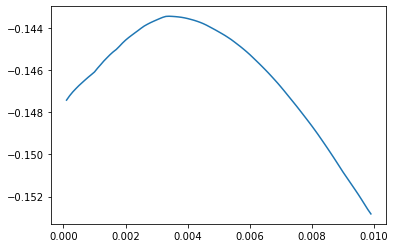

In [22]:
#For lasso regression, iterate through a range of alpha values and chose the value with the least error
alpha=[]
error=[]

for i in range(1,100):
    alpha.append(i/10000)
    lml=Lasso(alpha=(i/10000))
    error.append(np.mean(cross_val_score(lml,X_train, y_train, scoring='neg_mean_absolute_error',cv=3)))

plt.plot(alpha,error)
err=tuple(zip(alpha,error))
df_err=pd.DataFrame(err,columns=['alpha','error'])
df_err[df_err.error==max(df_err.error)]

In [23]:
#Try several different models. Due to the sparse nature of this data, we use normalized regresion techniques and tree based techniques

#Keep track of the score for each model
cv_scores_array=[]
cv_model_array=['Linear', 'Lasso', 'Random Forest', 'XGB', 'SVR', 'LGBM', 'Catboost']


#Linear regression
ln=LinearRegression()
ln.fit(X_train,y_train)
linear_score=np.average(cross_val_score(ln,X_train,y_train,scoring='neg_root_mean_squared_error',cv=3))
cv_scores_array.append(linear_score)


#For our final lasso model we chose the alpha that has the least error
lml=Lasso(alpha=.0014)
lml.fit(X_train,y_train)
lasso_score=np.average(cross_val_score(lml, X_train, y_train, scoring='neg_root_mean_squared_error',cv=3))
cv_scores_array.append(lasso_score)


#For Random forest use grid search to perform some hyperperameter tuning on rf model
rf = RandomForestRegressor()
parameters={'n_estimators':range(10,300,10), 'criterion':('mse','absolute_error'),'max_features':('auto','sqrt','log2')}
gs_rf=GridSearchCV(rf,parameters,scoring='neg_root_mean_squared_error', cv=3)
gs_rf.fit(X_train, y_train)
optimized_rf_score=gs_rf.best_score_
cv_scores_array.append(optimized_rf_score)


#We now try an XGBoost model
xgb=XGBRegressor()
params={'n_estimators': [50, 100, 500, 1000], 'max_depth':[3,4,5], 'learning_rate': [0.01,0.5,0.8]}
gs_xgb=GridSearchCV(xgb, params, cv=3, scoring='neg_root_mean_squared_error')
gs_xgb.fit(X_train, y_train)
optimized_xgb_score=gs_xgb.best_score_
cv_scores_array.append(optimized_xgb_score)


#SVR
svr=make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))
svr_score=np.average(cross_val_score(svr,X_train, y_train, scoring='neg_root_mean_squared_error',cv=3))
cv_scores_array.append(svr_score)


#LGBM
lightgbm = LGBMRegressor()
params={'n_estimators': [50, 100, 500, 1000,7000], 'max_depth':[3,4,5], 'learning_rate': [0.01,0.5,0.8], 'num_leaves':[4, 6, 10]}
gs_lgbm=GridSearchCV(lightgbm, params, cv=3, scoring='neg_root_mean_squared_error')
gs_lgbm.fit(X_train, y_train)
lgbm_score=gs_lgbm.best_score_
cv_scores_array.append(lgbm_score)


#Catboost 
grid={'n_estimators': [50, 100, 500, 1000,7000],'max_depth':[3,4,5], 'learning_rate':[0.05, 0.005, 0.0005],  'l2_leaf_reg':[1,3,5,9]}
catboost_model=CatBoostRegressor(verbose=False)
gs_catboost=catboost_model.randomized_search(grid,cv=3, X=X_train, y=y_train, verbose=False, plot=False)
catboost_score=np.mean(cv_rmse(catboost_model))
cv_scores_array.append(catboost_score)

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error


bestTest = 1.1747309
bestIteration = 49


bestTest = 0.2186618857
bestIteration = 499


bestTest = 0.1811930715
bestIteration = 217


bestTest = 0.1943355117
bestIteration = 6999


bestTest = 0.2297689804
bestIteration = 49


bestTest = 0.1861173373
bestIteration = 98


bestTest = 0.9707707682
bestIteration = 499


bestTest = 0.1836279693
bestIteration = 995


bestTest = 0.7639067957
bestIteration = 99


bestTest = 0.7755454517
bestIteration = 99

Training on fold [0/3]

bestTest = 0.1973142801
bestIteration = 186

Training on fold [1/3]

bestTest = 0.1870125739
bestIteration = 453

Training on fold [2/3]

bestTest = 0.1930789378
bestIteration = 244



In [24]:
#cv_scores_array[-1]=catboost_model.best_score_['learn']['RMSE']
#cv_scores_array[-1]=np.mean(cv_rmse(catboost_model))

In [25]:
cat_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04699699953198433,
 'score_function': 'Cosine',
 'task_type':

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


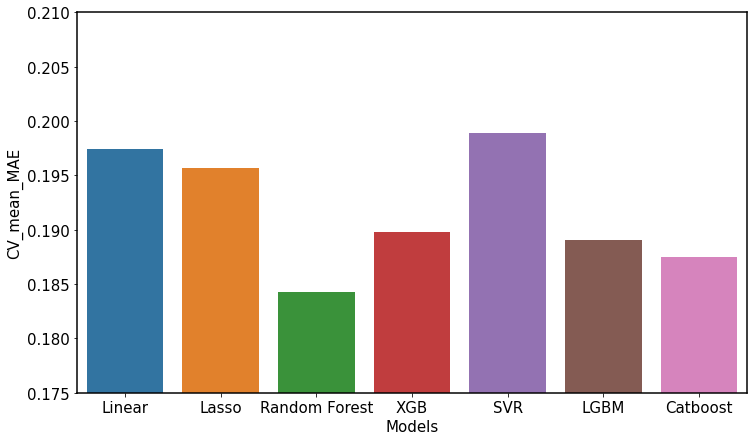

In [26]:
#Plot the scores for each model and compare to choose the best model

score_compare_dataframe=pd.DataFrame({'models':cv_model_array, 'scores':cv_scores_array})

plt.figure(figsize=(12,7))
plt.rcParams.update({'font.size': 15})
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
sns.barplot(score_compare_dataframe.models, np.abs(score_compare_dataframe.scores))
plt.xlabel('Models')
plt.ylabel('CV_mean_MAE')
plt.ylim([.175,0.21])
plt.show()

In [27]:
optimized_params=catboost_model.get_all_params()
optimized_params['verbose']=False

In [28]:
# Since the Catboost model performs the best, we choose this as our final model

#we first get the optimal parameters from the grid search
optimized_params=catboost_model.get_params()
optimized_params['verbose']=False

#We then make a  model with these optimized parameters
optimized_catboost_model = CatBoostRegressor(**optimized_params)

optimized_catboost_model.fit(X_train, y_train);

y_pred=optimized_catboost_model.predict(X_test);

mae(np.expm1(y_test), np.expm1(y_pred))

0.5459354073742384

In [29]:
# Random forest

#we first get the optimal parameters from the grid search
optimized_params=gs_rf.best_params_

#We then make a  model with these optimized parameters
optimized_rf_model = RandomForestRegressor(**optimized_params)

optimized_rf_model.fit(np.array(X_train), np.array(y_train));

y_pred=optimized_rf_model.predict(np.array(X_test));

mae(np.expm1(y_test), np.expm1(y_pred))

0.5589846074916622

In [30]:
#pickle the model so that it can be used in a flask app
pickl={'model':optimized_rf_model}
pickle.dump(pickl,open('model_file'+".p","wb"))

In [31]:
list(X.iloc[1,:])

[3.0,
 0.49677205178860884,
 0.8733832308628786,
 -1.8838470051076996,
 73.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [32]:
X.columns

Index(['num_bedrooms', 'num_baths', 'building_sqft', 'lot_area', 'house_age',
       'has_garage', 'has_fireplace', 'has_ocean_views', 'has_mountain_views',
       'has_hope_ranch', 'has_montecito', 'has_pool', 'has_upstairs', 'has_IV',
       'building_sqft_was_missing', 'zip_93067', 'zip_93101', 'zip_93103',
       'zip_93105', 'zip_93108', 'zip_93109', 'zip_93110', 'zip_93111',
       'zip_93117'],
      dtype='object')